In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from model import get_model
from dataset import get_dataset

2023-03-02 18:27:25.409622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 18:27:25.794956: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


KeyboardInterrupt: 

In [2]:
base_model, model = get_model(224)

2023-02-12 13:46:49.283035: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-02-12 13:46:49.283065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: michael
2023-02-12 13:46:49.283069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: michael
2023-02-12 13:46:49.283191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.89.2
2023-02-12 13:46:49.283207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.5
2023-02-12 13:46:49.283210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 525.85.5 does not match DSO version 525.89.2 -- cannot find working devices in this configuration
2023-02-12 13:46:49.

In [3]:
model.load_weights("model/model224.ckpt")

In [4]:
test_ds = get_dataset(False, 224, 1, 16)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [5]:
block1b_add = 13
block2a_expand_conv = 14
block2a_expand_activation = 16
block2a_project_conv = 17

In [6]:
names = [
    "block1b_add",
    "block2a_expand_conv",
    "block2a_expand_activation",
    "block2a_project_conv",
]

In [7]:
in_ftr_model = tf.keras.Model(
    inputs=base_model.input, outputs=base_model.layers[13].output
)

In [8]:
out_ftr_model = tf.keras.Model(
    inputs=base_model.layers[14].input,
    outputs=[
        base_model.layers[14].output,
        base_model.layers[16].output,
        base_model.layers[17].output,
    ],
)

In [9]:
activations = []
for i, (d, t) in enumerate(test_ds):
    if i == 40:
        break
    activations.append(in_ftr_model(d))

2023-02-10 17:03:58.503559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


In [10]:
l1 = tf.concat(activations, 0)

In [11]:
l2, l3, l4 = out_ftr_model(tf.concat(activations, 0))

2023-02-10 17:04:09.723241: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 748.18MiB (rounded to 784527360)requested by op Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-10 17:04:09.723461: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-02-10 17:04:09.723515: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 105, Chunks in use: 105. 26.2KiB allocated for chunks. 26.2KiB in use in bin. 14.0KiB client-requested in use in bin.
2023-02-10 17:04:09.723552: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 77, Chunks in use: 76. 50.5KiB allocated for chunks. 50.0KiB in use in bin. 44.9KiB client-requested in use in bin.
2023-02-10 17:04:09.723585: I tensorflow/tsl/framew

ResourceExhaustedError: Exception encountered when calling layer 'block2a_expand_conv' (type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[640,24,113,113] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Call arguments received by layer 'block2a_expand_conv' (type Conv2D):
  • inputs=tf.Tensor(shape=(640, 112, 112, 24), dtype=float32)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 4))
for e, (ax, arr) in enumerate(
    zip([axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]], [l1, l2, l3, l4])
):
    ax.hist(tf.math.reduce_std(arr, 0).numpy().flatten(), bins=100)
    ax.set_title(f"{names[e]} {'(in)' if e % 2 == 0 else '(out)'}")
fig.tight_layout()

In [42]:
type(base_model.layers[13].output_mask)

NoneType

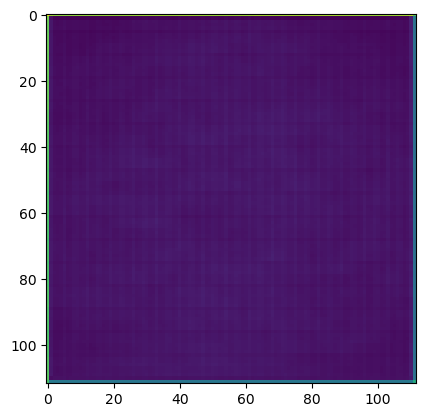

In [43]:
plt.imshow(tf.math.reduce_std(l1, [0, -1]))

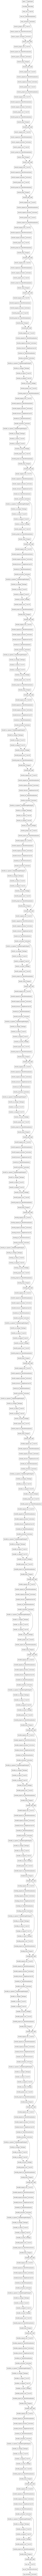

In [44]:
tf.keras.utils.plot_model(base_model)

In [16]:
base_model.layers[5].input.

TensorShape([None, 112, 112, 24])

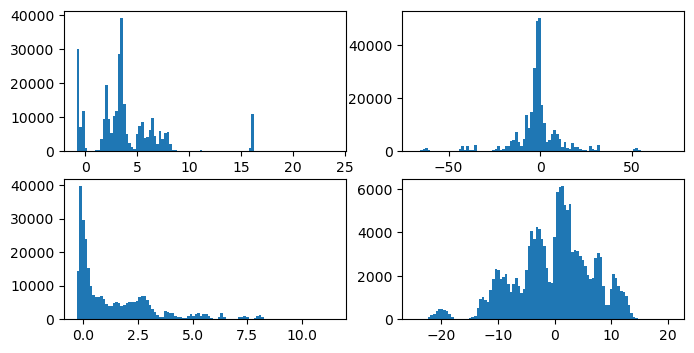

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(8, 4))
for ax, arr in zip([axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]], [l1, l2, l3, l4]):
    ax.hist(tf.math.reduce_mean(arr, 0).numpy().flatten(), bins=100)